In [2]:
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from collections import defaultdict
import numpy as np
import json
import pandas as pd
import seaborn as sns

from grid import Grid
from agent import Agent
from value_iteration import get_true_Qs
import neural_net

The following test grids are the same as those presented to humans in behavioral experiments. Each grid is defined by its initial starting configuration. The first digit of the grid number identifies the grid type:   

100s - push  
200s - switch   
300s - switch control  
400s - push control  

In [3]:
# Read in test grid specifications and convert to python format
TEST_GRIDS = {}
with open('../..//web_experiments/training_experiment/test_data.json') as json_file:
    grids = json.load(json_file)
    for gridnum, grid in grids.items():
        python_grid = {key: tuple(value) for key, value in grid.items() if key!="best_reward"}
        python_grid['best_reward'] = grid['best_reward']
        python_grid['num1'] = 1
        python_grid['num2'] = 2
        TEST_GRIDS[int(gridnum)] = python_grid

We probe the models defined in `agent.py` by presenting the grids defined in `TEST_GRIDS` and recording the reward achieved for a given number of monte-carlo rollouts (iterations). Because the results can depend on what actions were randomly explored for small iteration numbers, we repeat each (grid, iteration) pair to get more reliable, averaged results.

Specifically, we compare the dual-model (with Q-values initialized by neural network predictions) to the classic monte-carlo model

In [4]:
ITERS = [0,50,100,150,200,250]
REPEATS = 500 #number of times to redo the iteration for consistency

In [5]:
# Code used to simulate dual and MC agent runs over different number of iterations and save data to pickle
agent = Agent()
dual_scores = defaultdict(list) # maps gridnum to array of dual-model scores (averaged) for all iteration numbers in ITERS
mc_scores = defaultdict(list) # maps gridnum to array of monte-carlo scores (averaged) for all iteration numbers in ITERS
results = []

for i in ITERS:
    for gridnum, grid in TEST_GRIDS.items():
        if gridnum > 100:
            best_reward = grid['best_reward']
            for j in range(REPEATS):
                testgrid = Grid(init_pos=grid)
                Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=True)
                reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=True, display=False)
                dual_score = reward - best_reward 
                
                testgrid = Grid(init_pos=grid)
                Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=False)
                reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=False, display=False)
                mc_score = reward - best_reward 
                results.append([gridnum, 'dual', i, dual_score])
                results.append([gridnum, 'mc', i, mc_score])

results_df = pd.DataFrame(results, columns=['gridnum', 'model', 'iterations', 'score'])
results_df.to_csv('model_sim_data.csv', index=False)

In [110]:
model_sim_data = pd.read_csv('model_sim_data.csv')

# Removing grids 401, 405
#model_sim_data = model_sim_data[~model_sim_data['gridnum'].isin([401, 405])]

# Grouping data by gridnum, model, and iterations to get mean and standard error
grouped_data = model_sim_data.groupby([model_sim_data['gridnum']//100, 'model', 'iterations']).agg(
    mean_score=('score', 'mean'),
    std_error=('score', lambda x: x.std() / np.sqrt(len(x)))
).reset_index()

# Calculate the difference between dual and mc model scores and augment grouped data
diff_data = grouped_data.pivot(index=['gridnum', 'iterations'], columns='model', values='mean_score').reset_index()
diff_data['diff'] = diff_data['dual'] - diff_data['mc']
diff_data = diff_data.melt(id_vars=['gridnum', 'iterations'], value_vars=['dual', 'mc', 'diff'], var_name='model', value_name='mean_score')
grouped_data = pd.concat([grouped_data, diff_data[diff_data['model'] == 'diff']], ignore_index=True)

In [115]:
from scipy.interpolate import PchipInterpolator

def plot_model_sims(model):
    w, h = figaspect(1)
    fig, ax = plt.subplots(figsize=(w, h))
    
    # Loop through each unique gridnum and plot the data
    for gridnum in grouped_data['gridnum'].unique():
        grid_data = grouped_data[(grouped_data['gridnum'] == gridnum) & (grouped_data['model'] == model)]
        # Apply PchipInterpolator for smoothing
        pchip = PchipInterpolator(grid_data['iterations'], grid_data['mean_score'])
        x_smooth = np.linspace(grid_data['iterations'].min(), grid_data['iterations'].max(), 400)
        y_smooth = pchip(x_smooth)

        if gridnum == 1:
            label = 'Push'
            color = "#FF3B4B"
            linestyle = '-'
            linewidth = 4
        elif gridnum == 2:
            label = 'Switch'
            color = "#81CC18"
            linestyle = '--'
            linewidth = 4
        elif gridnum == 3:
            label = 'Switch Control'
            color = "#464D77"
            linestyle = '--'
            linewidth = 2
        elif gridnum == 4:
            label = 'Push Control'
            color = "#36827F"
            linestyle = '-'
            linewidth = 2

        ax.plot(x_smooth, y_smooth, label=label, color=color, linestyle=linestyle, linewidth=linewidth)

    # Adding labels and legend
    plt.xlabel("Number of Iterations", fontsize=14)
    plt.ylabel("Standardized Score", fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.show()

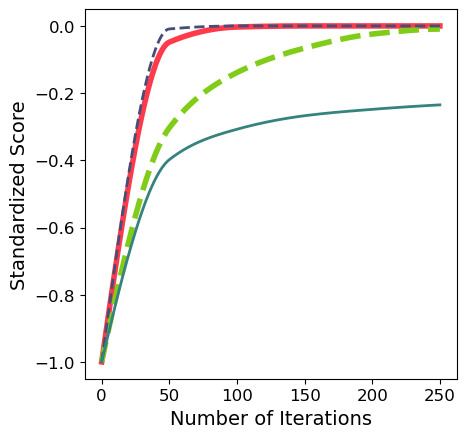

In [116]:
plot_model_sims('mc')

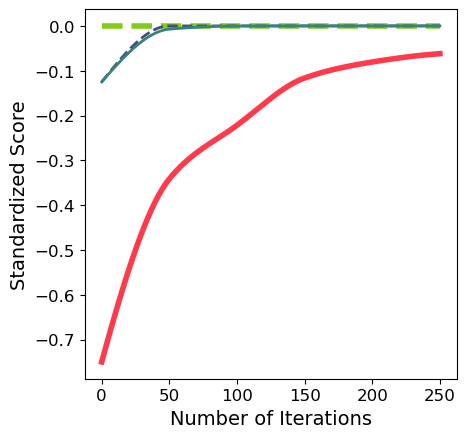

In [117]:
plot_model_sims('dual')

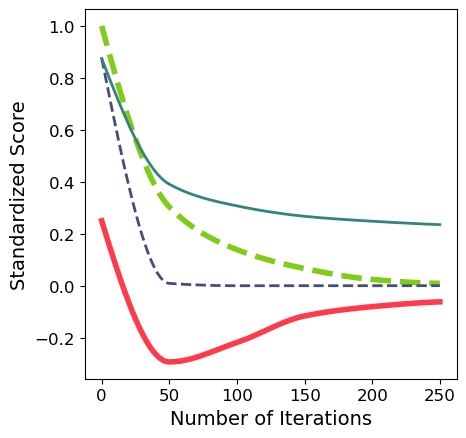

In [118]:
plot_model_sims("diff")

In [56]:
# Comparing CNN predictions to ground truth values for test grids of interest

def label(x):
    if x < 100: return "filler"
    if 100 < x < 200: return "Push"
    if 200 < x < 300: return "Switch"
    if 300 < x < 400: return "Switch Control"
    if 400 < x: return "Push Control"

net = neural_net.load()
lst = []
for gridnum, grid in TEST_GRIDS.items():
    if gridnum > 100:
        testgrid = Grid(init_pos=grid)
        # ground truth values for optimal grid state and action sequence
        s, a, r, is_action_of_interest = get_true_Qs(testgrid.copy(), get_is_action_of_interest=True)
        for step in range(5):
            NN_output = neural_net.predict(net, s[step])[0]
            error = ((NN_output - a[step]) ** 2).mean(axis=0) # Mean squared error
            accuracy = np.argmax(NN_output) in np.argwhere(a[step] == np.amax(a[step])) # Best action matches one of optimal actions
            best_action_diff = np.average(NN_output[a[step] == np.amax(a[step])]) - np.amax(a[step])   # Raw difference between predicted Q values for best action
            lst.append([gridnum, step, error, accuracy, best_action_diff, is_action_of_interest[step]])
nn_performance = pd.DataFrame(lst, columns = ['gridnum', 'step', 'error', 'accuracy', 'Signed Error', 'action of interest'])
nn_performance['Grid Type'] = nn_performance['gridnum'].apply(label)

/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_6362/1461560657.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=nn_performance[nn_performance['action of interest']==True], x="Grid Type", y="Signed Error", palette=color, capsize=0.03, err_kws={'linewidth':1.3, 'color':'black'})


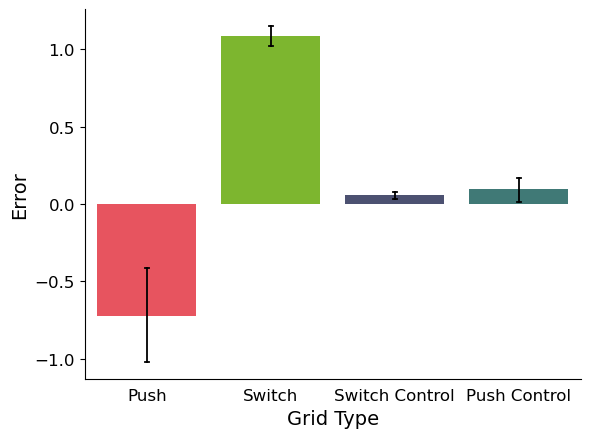

In [60]:
# Graph difference between CNN predicted Q-values and true Q-values for push/switch action of interest

sns.reset_defaults()
color=['#FF3B4B', '#81CC18', '#464D77', '#36827F']
ax = sns.barplot(data=nn_performance[nn_performance['action of interest']==True], x="Grid Type", y="Signed Error", palette=color, capsize=0.03, err_kws={'linewidth':1.3, 'color':'black'})
sns.despine()
plt.xlabel('Grid Type', fontsize=14)
plt.ylabel('Error', fontsize=14)
ax.tick_params(bottom=False, labelsize=12)
plt.show()